# Feature Extraction and Multiclass Classification of Kidney Ailments


## Importing Libraries

In [ ]:
pip install split-folders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import splitfolders
import seaborn as sns
import os
import random
import matplotlib.image as mpimg

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from collections import Counter

In [ ]:
def view_randon_images(target_dir,target_class):
    target_folder=target_dir+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    img=mpimg.imread(target_folder+"/"+random_image[0])
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(target_class)
    plt.axis("off")
    return img


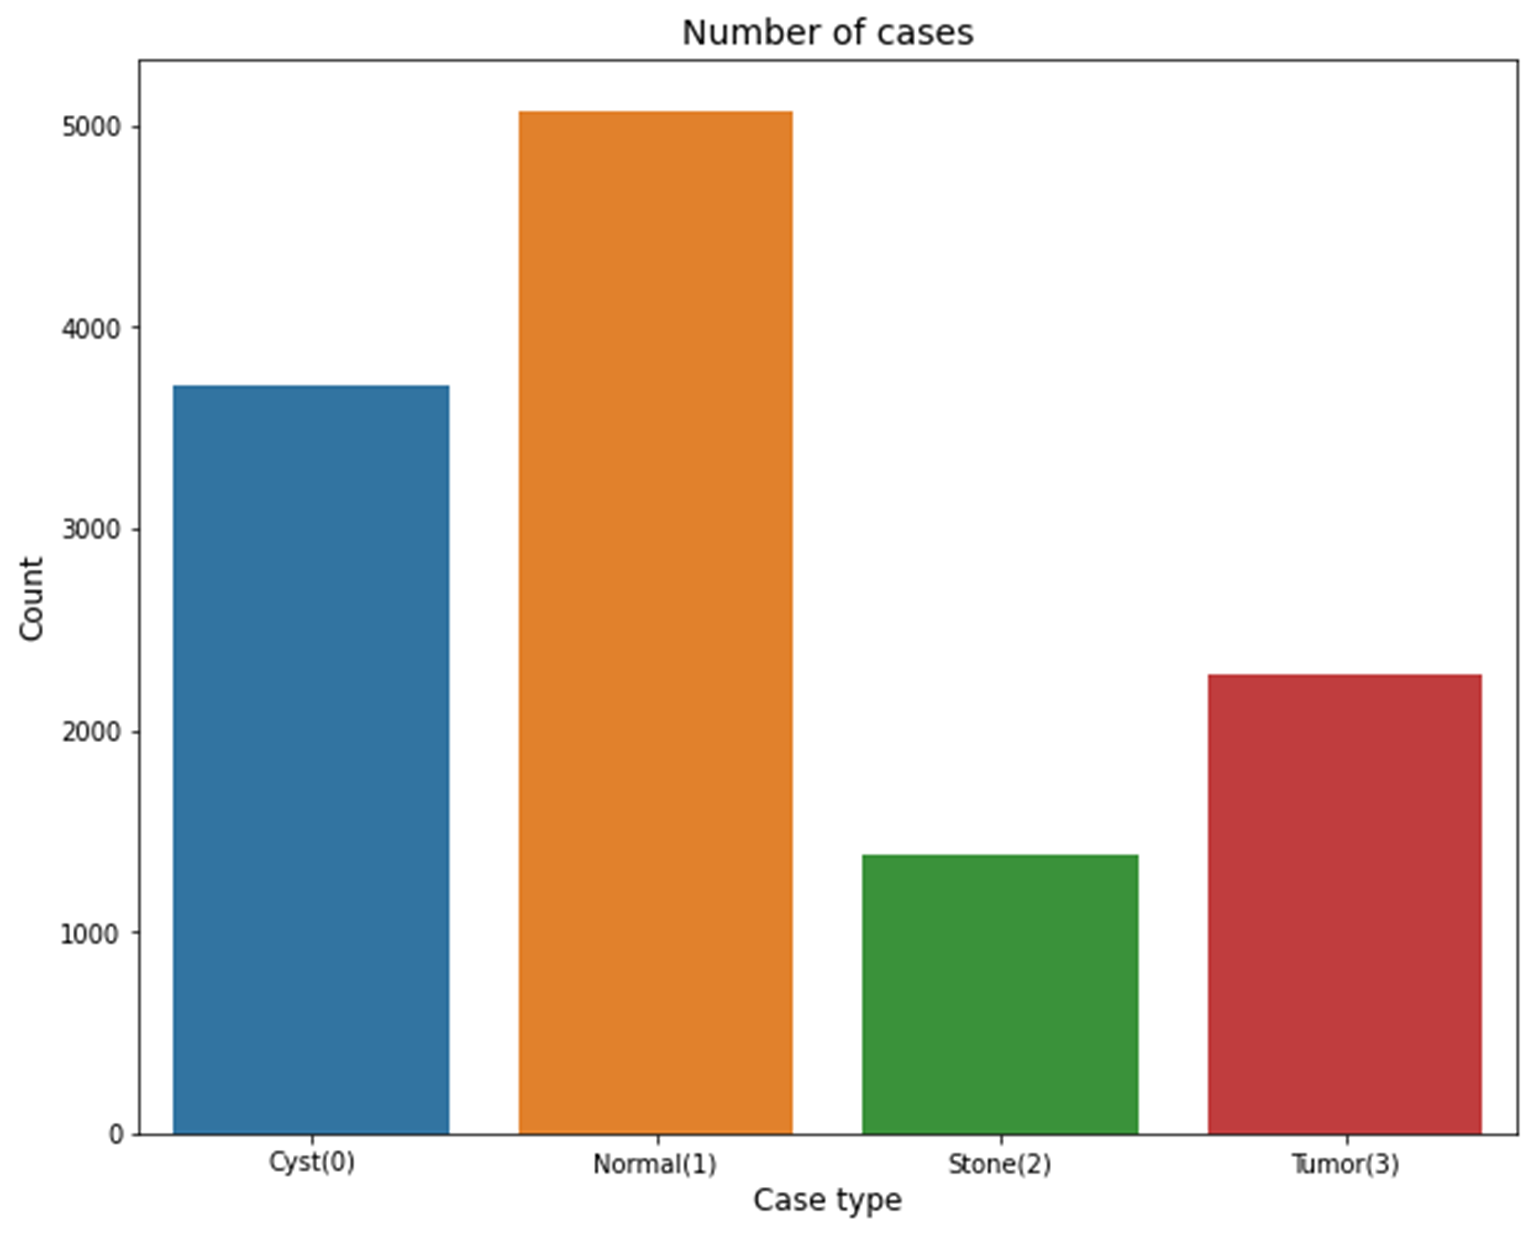!(http://)

## Splitting the dataset into Train, Test, and Validation Data 

In [ ]:
splitfolders.fixed("/kaggle/input/ctscans/Image Folder",output = "/kaggle/working/Split Folders", seed = 42, fixed=(300,300))

## Sample CT-Scans

In [ ]:
class_names=["Cyst","Normal","Stone","Tumor"]
plt.figure(figsize=(20,10))
for i in range(18):
    plt.subplot(3,6,i+1)
    class_name=random.choice(class_names)
    img=view_randon_images(target_dir="/kaggle/working/Split Folders/train/",target_class=class_name)

## Retrieving the Train, Test and Validation Images from the respective folders and storing them in the form of an array

In [ ]:
train_images = []
train_labels = [] 

for directory_path in glob.glob("/kaggle/working/Split Folders/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
np.unique(train_labels)

In [ ]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/kaggle/working/Split Folders/test/*"):
    _label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(_label)            
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
valid_images = []
valid_labels = [] 
for directory_path in glob.glob("/kaggle/working/Split Folders/val/*"):
    _labels = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        valid_images.append(img)
        valid_labels.append(_labels)

                
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)


In [ ]:
train_images.shape, test_images.shape, valid_images.shape

In [ ]:
train_labels.shape, test_labels.shape, valid_labels.shape

## Number of images in each class

In [ ]:
train_counter = Counter(train_labels)
test_counter =Counter(test_labels)
val_counter =Counter(valid_labels)
print("Number of Images in each Class:")
print("Train: ", train_counter)
print("Test: ", test_counter)
print("Valid: ", val_counter)

## Label Encoding each of the target variables

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)


le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

le.fit(valid_labels)
valid_labels_encoded =le.transform(valid_labels)

In [ ]:
np.unique(train_labels_encoded)

## Assigning the train, test and validation  images and labels to their respective images and encoded labels 

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = train_images, train_labels_encoded, test_images, test_labels_encoded, valid_images, valid_labels_encoded

In [ ]:
x_train.shape, x_test.shape, x_val.shape

## Importing the VGG16 model. We set the inlcude_top parameter to False, to consider only the feature extraction layer

In [ ]:
VGG_model = VGG16( weights='imagenet', include_top=False, input_shape=(224,224, 3))

## We will set the layers as non-trainable, so that we can use the pre-trained weights

In [ ]:
for layer in VGG_model.layers:
    layer.trainable = False

## Summary of the model

In [ ]:
VGG_model.summary()

## Extracting features  and using this feature for the classification model

In [ ]:
feature_extractor=VGG_model.predict(x_train)

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_RF = features

In [ ]:
features

## Loading the Random Forest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier( random_state = 42)

## Passing the extracted features from the VGG16 model to the random forest classifier

In [ ]:
RF_model.fit(X_for_RF, y_train)

## Prediction 

In [ ]:
X_test_feature = VGG_model.predict(x_val)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
prediction_RF = RF_model.predict(X_test_features)
prediction_RF = le.inverse_transform(prediction_RF)
np.unique(prediction_RF)

## Evaluation 

In [ ]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ["Cyst","Normal","Stone","Tumor"]
cm = confusion_matrix(test_labels, prediction_RF)
sns.heatmap(cm, annot=True,xticklabels =labels, yticklabels =labels,square=True)

In [ ]:
print(classification_report(test_labels, prediction_RF))

In [ ]:
def test_img(img, n):
    input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
    input_img_feature=VGG_model.predict(input_img)
    input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction_RF = RF_model.predict(input_img_features)[0] 
    prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
    print("The prediction for this image is: ", prediction_RF)
    print("The actual label for this image is: ", test_labels[n])


In [ ]:
n1 = np.random.randint(0, x_test.shape[0])
img1 = x_test[n1]
plt.imshow(img1)
test_img(img1,n1)

In [ ]:
n2 = np.random.randint(0, x_test.shape[0])
img2 = x_test[n2]
plt.imshow(img2)
test_img(img2,n2)



In [ ]:
n3 = np.random.randint(0, x_test.shape[0])
img3 = x_test[n3]
plt.imshow(img3)
test_img(img3,n3)



In [ ]:
n4 = np.random.randint(0, x_test.shape[0])
img4 = x_test[n4]
plt.imshow(img4)
test_img(img4,n4)

In [ ]:
n5 = np.random.randint(0, x_test.shape[0])
img5 = x_test[n5]
plt.imshow(img5)
test_img(img5,n5)
